In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import set_config
set_config(print_changed_only = False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Load Data

In [61]:
from google.colab import drive
drive.mount('/content/drive/')
#Load data

# df_true = pd.read_csv("/content/drive/My Drive/Uni/IS424/Data/Real_Data.csv")
# df_fake = pd.read_csv("/content/drive/My Drive/Uni/IS424/Data/Fake_Data.csv")
df = pd.read_csv("/content/drive/My Drive/Uni/IS424/final_combined with sentiment.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [62]:
GLOVE_EMBEDDING = "/content/drive/My Drive/Uni/IS424/Data/glove.twitter.27B.100d.txt"

In [63]:
df_true["news_class"], df_fake["news_class"] = 1, 0

# news_after_make_concate = pd.concat([df_true, df_fake])

In [64]:
df.head()

,label,text,vader,vader_final,vader_label,blob_polarity,blob_subjectivity
0,fake,hey hillary who is really behind attempt by pa...,"{'neg': 0.064, 'neu': 0.861, 'pos': 0.074, 'co...",0.3071,positive,-0.020313,0.323065
1,real,after question on foreign meddling in brexit u...,"{'neg': 0.032, 'neu': 0.926, 'pos': 0.041, 'co...",0.6105,positive,0.074191,0.347634
2,real,acting sec chair seeks to scale back conflict ...,"{'neg': 0.107, 'neu': 0.854, 'pos': 0.039, 'co...",-0.9822,negative,0.027423,0.411593
3,fake,trump threatens to sue illegal immigrant activ...,"{'neg': 0.103, 'neu': 0.818, 'pos': 0.079, 'co...",-0.9538,negative,0.049472,0.412390
4,real,russia ready to rebuild security ties with u s...,"{'neg': 0.086, 'neu': 0.789, 'pos': 0.125, 'co...",0.9411,positive,0.036300,0.376185


Drop Duplicates

In [65]:
df.drop_duplicates(inplace=True)

**CLEAN DATA**

In [66]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [68]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

In [71]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['hey', 'hillary', 'really', 'behind', 'attempt']

In [72]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'trump': 135094,
 'said': 121638,
 'u': 54484,
 'president': 49775,
 'would': 49708,
 'people': 37685,
 'one': 33084,
 'state': 31469,
 'new': 29897,
 'reuters': 28746}

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Unigram Analysis

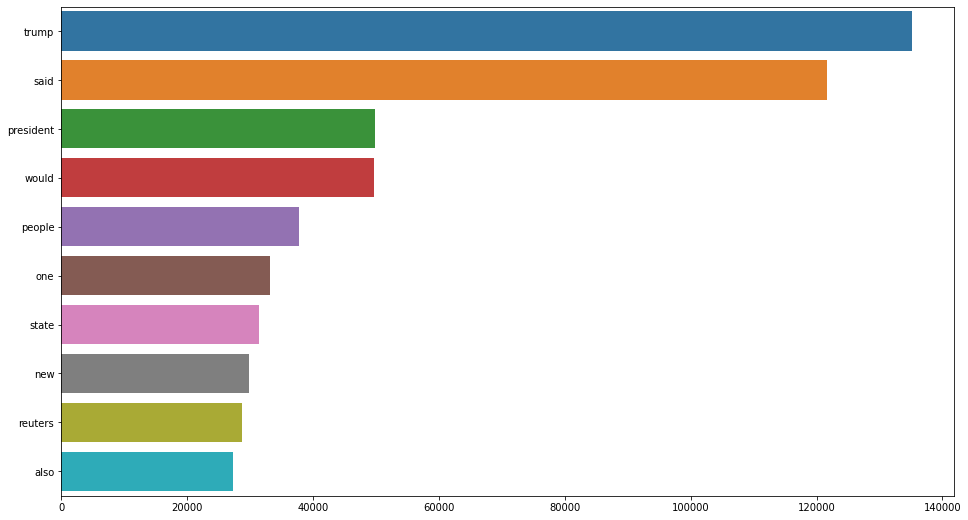

In [77]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

Bigram Analysis

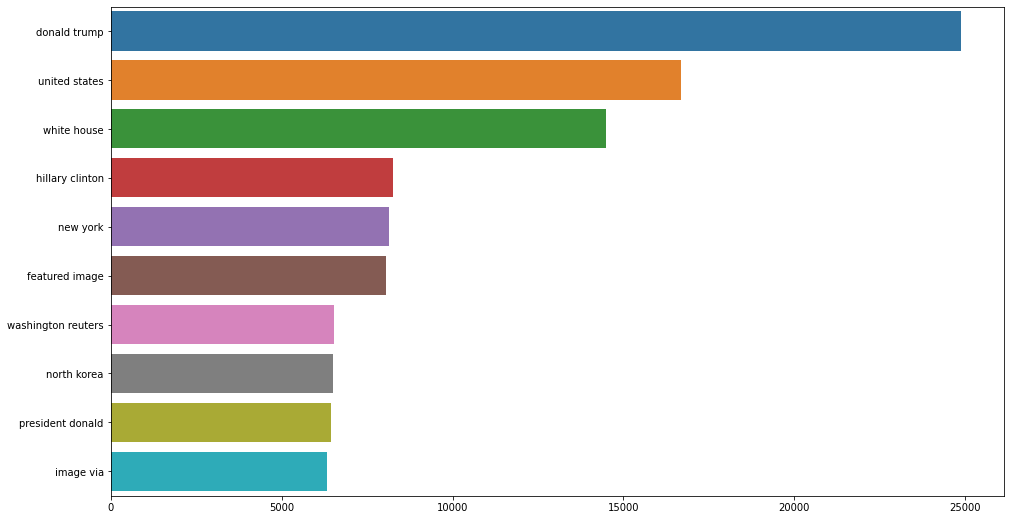

In [78]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

Split the Data

In [79]:
# Spliting the data

x = df["text"]
y = df["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 11)

print("Shape of the train data: ",x_train.shape)
print("Shape of the test data: ",x_test.shape)

Shape of the train data:  (37593,)
Shape of the test data:  (9399,)


In [76]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)

train_x = keras.utils.pad_sequences(tokenized_train, maxlen = 300)
test_x = keras.utils.pad_sequences(tokenized_test, maxlen = 300)

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))
embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(10000, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

Building the Model

In [ ]:
model = Sequential()

model.add(Embedding(10000,
                    output_dim = 100,
                    weights = [embedding_matrix],
                    input_length = 300,
                    trainable = False))
model.add(Bidirectional(LSTM(150))),

model.add(Dense(units = 32,
                activation = "relu"))
model.add(Dense(1,
                activation = "sigmoid"))

In [ ]:
model.summary()

In [ ]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [ ]:
y_train.shape

In [ ]:
history = model.fit(train_x,
                    y_train,
                    batch_size = 128,
                    validation_data = (test_x, y_test),
                    epochs = 5, 
                    callbacks = [lr_reduce])

In [ ]:
epochs = [i for i in range(5)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = (model.predict(test_x) > 0.5).astype("int32")

In [ ]:
# calc the classes pred
classes_pred = np.argmax(predictions, axis = 1)

print(classification_report(y_test, classes_pred))

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(train_x,y_train)[1]*100 , "%")
print("*********************************************************************************************")
#98.96145

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(test_x,y_test)[1]*100 , "%")
#97.400

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Real'] , columns = ['Fake','Real'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])
plt.xlabel("Predicted")
plt.ylabel("Actual")